In [2]:
import bisect
import math
import struct as st

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from random import sample
from numpy.random import RandomState

from sklearn import decomposition

In [18]:
img_side_len = 28 # side length of each image, in pixels

rng = RandomState(1289) # arbitrary random state seed

pct_var_cutoff = 98 # target percent variance explained by PC space

In [4]:
def plot_components(dictionary, cmap):
    ''' Plots dictionary components (row vectors of data) as 2d images
    
    Note: assumes size of each component equals # of pixels per image in the original MNIST data
    
    Parameters
    ----------
    dictionary: (numpy array, [# of representations] x [# of pixels per image])
    
    '''
    
    max_rows = 12;
    
    n_cols = 20;
    n_rows = min(max_rows, math.ceil(np.size(dictionary,0)/n_cols))
    
    plt.figure()
    for i, img_rep in enumerate(dictionary[:n_cols*n_rows]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img_rep.reshape((img_side_len,img_side_len)), cmap = cmap)
        plt.gca().set_axis_off()
        
    plt.show()

# Convert MNIST dataset to Numpy arrays

In [5]:
filename = {'train_images' : 'train-images-idx3-ubyte', 'test_images' : 't10k-images-idx3-ubyte'}

In [7]:
def get_image_array(dataset_name):
    ''' Convert MNIST binary data to Numpy array of pixel data for each image
    
    Parameters
    ----------
    dataset_name: (str) name of MNIST dataset ('train_images' or 'test_images')
    
    Returns
    -------
    images_array: (numpy array, [# of images] x [# of pixels per image]) array of vectorized pixel data for each image
    
    '''
    
    with open('../'+filename[dataset_name],'rb') as images_file:
        images_file.seek(0)
        magic = st.unpack('>4B',images_file.read(4)) # magic number (0, 0, 8 = data type, 3 = # of dimensions)

        n_imgs = st.unpack('>I',images_file.read(4))[0] # number of images
        n_rows = st.unpack('>I',images_file.read(4))[0] # number of rows
        n_cols = st.unpack('>I',images_file.read(4))[0] # number of columns

        n_bytes_total = n_imgs*n_rows*n_cols
        
        images_array = np.zeros((n_imgs,n_rows,n_cols))
        images_array = 255 - \
            np.asarray(st.unpack('>'+'B'*n_bytes_total, images_file.read(n_bytes_total))).reshape((n_imgs,n_rows*n_cols))
    
    return images_array

In [8]:
# Convert MNIST training and test image data from binary files to numpy arrays
train_data = get_image_array('train_images')
test_data = get_image_array('test_images')

# Perform PCA on MNIST data

In [21]:
# Initialize PCA object
pca_model = decomposition.PCA(whiten = True, random_state = rng)

# Zero-average training data
train_data_zeroavg = train_data - np.mean(train_data, 0)

# Perform PCA with no restrictions on number of components, then evaluate variance explained by first n components
pca_model.fit(train_data_zeroavg)

PCA(copy=True, iterated_power='auto', n_components=None,
  random_state=<mtrand.RandomState object at 0x1a258b2f78>,
  svd_solver='auto', tol=0.0, whiten=True)

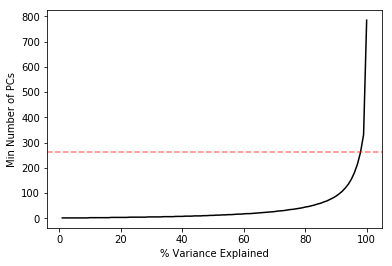

In [27]:
cum_var_explained = np.cumsum(pca_model.explained_variance_ratio_)

pct_var_explained = range(1,101,1)
n_pcs = [bisect.bisect(cum_var_explained, pct_var/100.)+1 for pct_var in pct_var_explained]

n_pcs_cutoff = bisect.bisect(cum_var_explained, pct_var_cutoff/100.)+1

% matplotlib inline
plt.plot(pct_var_explained,n_pcs,'k')
plt.axhline(y = n_pcs_cutoff, color = 'r', linestyle = '--', alpha = .5)

plt.xlabel('% Variance Explained')
plt.ylabel('Number of PCs')

plt.show()

In [28]:
print(n_pcs_cutoff)

261


In [9]:
# Redo PCA with just enough PCs to hit the target percent variance explained
pca_model = decomposition.PCA(n_components = n_pcs_cutoff,
                              whiten = True,
                              random_state = rng)

pca_model.fit(train_data_zeroavg)

train_data_pc = pca_model.transform(train_data_zeroavg) # Compressed PC-space representation of training data

# Train sparse coding model on MNIST data

In [10]:
dictionary_size =  n_pcs*2 # number of components in dictionary
alpha = .5 # sparseness parameter
n_iter = 500 # number of iterations

# Initialize MNIST sparse coding model
sparse_model = decomposition.MiniBatchDictionaryLearning(n_components = dictionary_size,
                                                 alpha = alpha,
                                                 fit_algorithm = 'cd',
                                                 n_iter = n_iter,
                                                 random_state = rng)
# Fit model
sparse_model.fit(train_data_pc)

MiniBatchDictionaryLearning(alpha=0.5, batch_size=3, dict_init=None,
              fit_algorithm='cd', n_components=522, n_iter=500, n_jobs=1,
              random_state=<mtrand.RandomState object at 0x1a16abdb88>,
              shuffle=True, split_sign=False, transform_algorithm='omp',
              transform_alpha=None, transform_n_nonzero_coefs=None,
              verbose=False)

In [11]:
components = pca_model.inverse_transform(sparse_model.components_) # get components in pixel space

k_components = 50
inds = sample(range(np.size(components,0)),k_components)
components_subset = components[inds,:]

In [ ]:
%matplotlib qt
plot_components(components_subset, 'coolwarm')

In [47]:
%matplotlib qt
fig, axs = plt.subplots(nrows=2, ncols=5, sharex = True, sharey = True, constrained_layout=True)
for i,ax in zip(range(10),axs.reshape((10,1))):
    ax[0].imshow(components[i,:].reshape((img_side_len,img_side_len)), cmap = 'coolwarm')
plt.show()

In [58]:
fig.subplots_adjust(hspace=0,wspace=.1)